# Multi-component fit

This example shows how to use `lmfit_global.py` to fit data with multi-components. 

This example is similar to `doc_builtinmodels_nistgauss.py` of [lmfit examples](https://lmfit.github.io/lmfit-py/examples/index.html) or [github link](https://github.com/lmfit/lmfit-py/tree/master/examples)


In [1]:
try:
    from lmfit_global import LmfitGlobal
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../lmfit_global')
    from lmfit_global import LmfitGlobal
    
import matplotlib.pyplot as plt

load raw data...

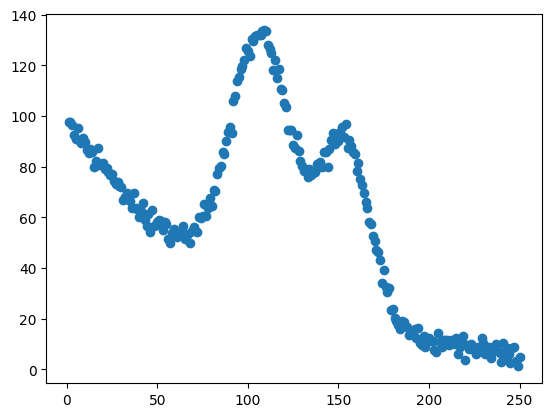

In [2]:
import os
import numpy as np
dpath = './data'  # data path

# --- Load data (skip header) ---
file='NIST_Gauss2.dat' # data
file=os.path.join(
    dpath,
    file
)

dat = np.loadtxt(file)
x = dat[:, 1]  # second column as x
y = dat[:, 0]  # first  columm as y

#  --- make column data as [x, y]  ---
#  --- lets use numpy.column_stack ---
xy = np.column_stack([x, y])

# plot raw data
plt.figure()
plt.plot(x, y, 'o')

# --- From the plot below, it looks as the data can be fitted with the SUM of ---
# --- ONE exponential function and TWO gaussian centered around x = 100 & 150 ---

built the functions... 

In [3]:
import os
import numpy as np
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))

def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * np.exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


def exponential(x, amplitude=1, decay=1):
    """Return an exponential function.

    exponential(x, amplitude, decay) = amplitude * exp(-x/decay)

    """
    decay = not_zero(decay)
    return amplitude * np.exp(-x/decay)


built `data` and `function` **`item`** `dict` for `LmfitGlobal` ...

In [4]:
# data dict
data_dict = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }


func_lst = [
    {
        'func_name': exponential,
        'init_params' : {
            'amplitude': {'value':110.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'decay': {'value':80, },
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':100, },
            'sigma': {'value':15, },
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':150, },
            'sigma': {'value':13, },
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
]

# function dict
function_dict = {
    'theory': func_lst,
    'theory_connectors': ['+', '+',],
}


# """
# # --- The `theory_connectors` (list of str): 
#     A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
#     the theory functions listed in 'theory'. Each operator connects one function to the next 
#     in left-to-right order. 
    
#     For example: 
#     - ['+', '+'] means: theory[0] + theory[1] + theory[2].

#     - ['+', '*'] means: theory[0] + theory[1] * theory[2].

#     The number of connectors must be exactly one less than the number of theory functions.
#     The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
# """


# items 
items = {
    'data': data_dict,              # 1. data (see above)
    'functions': function_dict,     # 2. thoery (see above)
}

call `LmfitGlobal` ...

In [5]:
LFG = LmfitGlobal(items)
# --- The box below show how the model y(x) (CompositeModel) is define using `theory_connectors` define above ---
# --- it is upto the USER to define how to define the CompositeModel ---
# --- if you are HAPPY proceed NEXT

INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: #############################################################################
INFO: # y(x;) = exponential(x, amplitude, decay) + gaussian(x, amplitude, center, #
INFO: # sigma) + gaussian(x, amplitude, center, sigma)                            #
INFO: #############################################################################


print & plot initial parameter definitions...

Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0       110     -inf      inf     None     True     None     None
c0_decay_0            80     -inf      inf     None     True     None     None
c1_amplitude_0      2000     -inf      inf     None     True     None     None
c1_center_0          100     -inf      inf     None     True     None     None
c1_sigma_0            15     -inf      inf     None     True     None     None
c2_amplitude_0      2000     -inf      inf     None     True     None     None
c2_center_0          150     -inf      inf     None     True     None     None
c2_sigma_0            13     -inf      inf     None     True     None     None


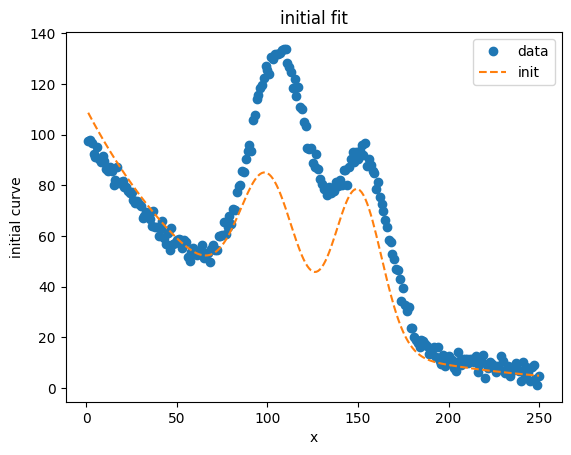

In [6]:
LFG.initial_params.pretty_print()  # pretty print initial parameters

axes0 = LFG.plot_init()  # plot init parameters

do fit...

In [7]:
LFG.fit(verbose=True)  # verbose, if True will show fit parameters

INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: c0_amplitude_0     99.02     -inf      inf   0.5375     True     None     None
INFO: c0_decay_0         90.95     -inf      inf    1.103     True     None     None
INFO: c1_amplitude_0      4258     -inf      inf    42.38     True     None     None
INFO: c1_center_0          107     -inf      inf   0.1501     True     None     None
INFO: c1_sigma_0         16.67     -inf      inf   0.1605     True     None     None
INFO: c2_amplitude_0      2493     -inf      inf    36.17     True     None     None
INFO: c2_center_0        153.3     -inf      inf   0.1947     True     None     None
INFO: c2_sigma_0         13.81     -inf      inf   0.1868     True     None     None
INFO: Coefficient of determination: R² = 0.99648654 (uniform average)...
INFO: Coefficient of determination: R² = 0.99648654 (variance-weighted)...


plot fit...

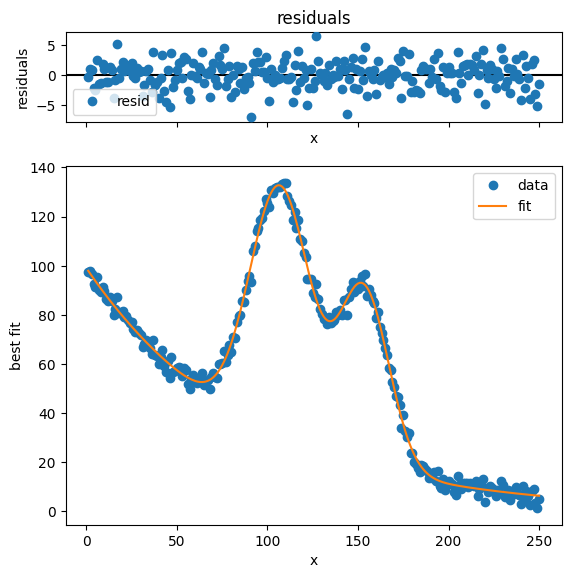

In [8]:
axes1 = LFG.plot(show_init=False)   # plot fit data & residuals and show initial plot (if True)

plot fit with no residuals... use `.plot_fit()`...

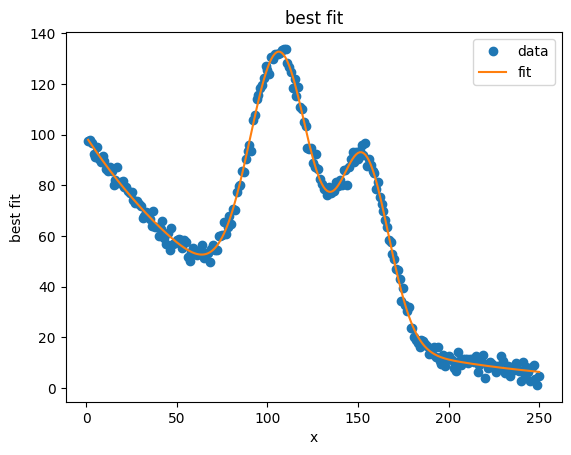

In [9]:
axes2 = LFG.plot_fit()

report...

In [10]:
LFG.report()

[[Model]]
    ((Model(exponential, prefix='c0_') + Model(gaussian, prefix='c1_')) +
     Model(gaussian, prefix='c2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 250
    # variables        = 8
    chi-square         = 1247.52821
    reduced chi-square = 5.15507524
    Akaike info crit   = 417.864631
    Bayesian info crit = 446.036318
    R-squared          = 0.99648654
[[Variables]]
    c0_amplitude_0:  99.0183284 +/- 0.53748607 (0.54%) (init = 110)
    c0_decay_0:      90.9508806 +/- 1.10310754 (1.21%) (init = 80)
    c1_amplitude_0:  4257.77403 +/- 42.3837486 (1.00%) (init = 2000)
    c1_center_0:     107.030957 +/- 0.15006843 (0.14%) (init = 100)
    c1_sigma_0:      16.6725790 +/- 0.16048211 (0.96%) (init = 15)
    c2_amplitude_0:  2493.41720 +/- 36.1694865 (1.45%) (init = 2000)
    c2_center_0:     153.270104 +/- 0.19466642 (0.13%) (init = 150)
    c2_sigma_0:      13.8069457 +/- 0.18680009 (1.35%) (init = 13)
[[Corre

NOTE: The use of `.plot_dat()`, `.plot_init()`, `.plot_fit()` & `.plot()` require `matplotlib` installed...

Below will show how you can use your desire plotting tools...

First,  evaluate fit... 

Second, evaluate components (IF ANY), if required, when dealing with multi-components....

Third, optional, you can evaluate the fit and components with more dense points...

In this examples, we fit data using 3 components...
so we expect 3 components data per dataset...

In [11]:
# --- fit data
yfit = LFG.eval()                     # evaluate with x raw data define above
yfit = LFG.eval(x=x)                  # evaluate with x raw data define above (same as above)
xfit = np.linspace(0, 300, num=500)   # if more dense data is needed
yfit = LFG.eval(x=xfit)               # dense 

# --- components
# use .eval_components() or .eval_components_per_dataset()
comps = LFG.eval_components()         # evaluate with x raw data define above
comps = LFG.eval_components(x=x)      # evaluate with x raw data define above (same as above)
comps = LFG.eval_components(x=xfit)   # dense 
# evaluate fit per datasets
# since we are dealing with single dataset
# we expect dict['0'], for n datasets dict['0', '1', '2', ...'n-1']
print('dataset label = ', list(comps.keys()))
# since we are dealin with three components,
# each dataset will have dictionary of 3 component label 'c0', 'c1', 'c2'
print('component label of dataset "0" = ', list(comps['0'].keys()))
# where 'c0', 'c1' and 'c2' are exponential, gaussian 1 and gaussian 2 componets
# i.e. in order of how they are define in `func_lst` above

# --- Also, we can extract initial and best fit as ---
init_fit = LFG.init_fit   # default with x raw data
best_fit = LFG.best_fit   # default with x raw data

# --- plot as you desired favorite 

dataset label =  ['0']
component label of dataset "0" =  ['c0', 'c1', 'c2']


plot as you desired...

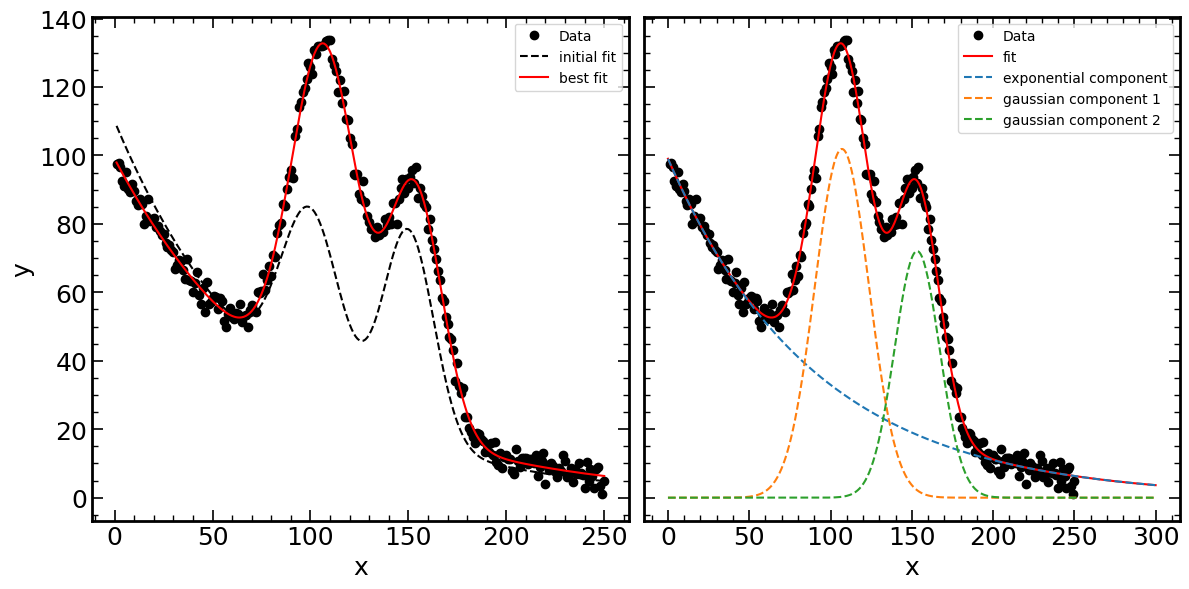

In [12]:
# --- create subplots panel ----
fontsize=18
fig = plt.figure(
    figsize=(12, 6),
    layout='tight' # 'constrained', 'compressed', 'tight', 'none', `.LayoutEngine`, None; default: None
)
axes = fig.subplots(
    nrows=1,
    ncols=2,
    sharex=False,
    sharey=True,
)
for ax in axes.ravel():
    # Major ticks
    ax.tick_params(
        axis='both',
        which='major',
        direction='in',
        length=8,       # major tick length
        width=1.2,      # major tick width
        labelsize=fontsize+0,
        labelcolor='k'
    )

    # Minor ticks
    ax.tick_params(
        axis='both',
        which='minor',
        direction='in',
        length=4,       # minor tick length
        width=1.0       # minor tick width
    )
    ax.tick_params(
        axis='both', which='both',
        top=True, bottom=True, 
        left=True, right=True
        )
    for spine in ax.spines.values():
        spine.set_linewidth(2)   # choose thickness you want

    
    ax.set_xlabel('x', fontsize=fontsize)

    ax.minorticks_on()
axes[0].set_ylabel('y', fontsize=fontsize)


axes[0].plot(x, y, 'ko', label='Data')   # raw data
axes[1].plot(x, y, 'ko', label='Data')   # raw data

axes[0].plot(x, init_fit, 'k--', label='initial fit')
axes[0].plot(x, best_fit, 'r-',  label='best fit')

axes[1].plot(xfit, yfit, 'r-', label='fit')
axes[1].plot(xfit, comps['0']['c0'], '--', label='exponential component')
axes[1].plot(xfit, comps['0']['c1'], '--', label='gaussian component 1')
axes[1].plot(xfit, comps['0']['c2'], '--', label='gaussian component 2')

for ax in axes.ravel():
    ax.legend()